# Save Ising data into binary files, for each epoch

In [56]:
import numpy as np
import os
import pickle as cPickle

In [46]:
def Ising2D_to_epochs(rawdata_fname_base='cube_L1000_D2_T',save_file=False, num_epoch=2, base='/Users/qinglingzhang/Ising_SW/Ising2D', M=100, N=100, T_length=6):
    epoch_fnames = {}
    for rawdata_file in sorted(os.listdir(base)):
        if not rawdata_file.startswith(rawdata_fname_base) or 'epoch' in rawdata_file:
            continue
        
        print('Parsing',rawdata_file)
        T = rawdata_file[len(rawdata_fname_base):len(rawdata_fname_base)+T_length]
        epoch_fnames[T] = []
        
        raw_data = np.loadtxt(base + '/'+ rawdata_file, delimiter=None)
        num_sample,num_node = raw_data.shape
        print('raw_data shape:',raw_data.shape)
        
        for epoch in range(num_epoch):
            num_batch = num_sample//num_epoch
            begin = epoch*num_batch
            end = (epoch+1)*num_batch
            epoch_data = raw_data[begin:end,:]
            epoch_activity = list(epoch_data.T.reshape(N,M,num_batch).swapaxes(1,2))
            data = {'T': T,
                    'epoch':epoch, 
                    'activity': epoch_activity}
            epoch_fname = base + '/' + rawdata_file + '_epoch' + str(epoch+1) + "_" + str(num_epoch)
            
            epoch_fnames[T].append(epoch_fname)
            print("Making File:", epoch_fname)
            if save_file:
                with open(epoch_fname, 'wb') as f:
                    cPickle.dump(data, f, cPickle.HIGHEST_PROTOCOL)
    with open(base+'/'+'epochdata_fnames','wb') as f:
        cPickle.dump(epoch_fnames, f, cPickle.HIGHEST_PROTOCOL)
    return epoch_fnames

epoch_fnames = Ising2D_to_epochs()


Parsing cube_L1000_D2_T1.5000_pBC
raw_data shape: (2000, 10000)
Making File: /Users/qinglingzhang/Ising_SW/Ising2D/cube_L1000_D2_T1.5000_pBC_epoch1_2
Making File: /Users/qinglingzhang/Ising_SW/Ising2D/cube_L1000_D2_T1.5000_pBC_epoch2_2
Parsing cube_L1000_D2_T2.2692_pBC
raw_data shape: (2000, 10000)
Making File: /Users/qinglingzhang/Ising_SW/Ising2D/cube_L1000_D2_T2.2692_pBC_epoch1_2
Making File: /Users/qinglingzhang/Ising_SW/Ising2D/cube_L1000_D2_T2.2692_pBC_epoch2_2
Parsing cube_L1000_D2_T3.5000_pBC
raw_data shape: (2000, 10000)
Making File: /Users/qinglingzhang/Ising_SW/Ising2D/cube_L1000_D2_T3.5000_pBC_epoch1_2
Making File: /Users/qinglingzhang/Ising_SW/Ising2D/cube_L1000_D2_T3.5000_pBC_epoch2_2


In [57]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict, OrderedDict
import keras.backend as K
import kde
import simplebinmi
import utils
trn, tst = utils.get_mnist()

# Which measure to plot: 'upper', 'bin', 'lower'
infoplane_measure = 'upper'

DO_SAVE        = False    # Whether to save plots or just show them
DO_LOWER       = True    # (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = False    #(infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

# Max number of epoch for which to compute mutual information measure
MAX_EPOCHS = 10000      

COLORBAR_MAX_EPOCHS = 10000

# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 1e-1                    # Added Gaussian noise variance
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 
with open('epochdata_fnames', 'rb') as f:
    epoch_fnames =cPickle.load(f)
Ts = epoch_fnames.keys()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# Save indexes of tests data for each of the output classes
saved_labelixs = {}
for i in range(10):
    saved_labelixs[i] = tst.y == i


print(saved_labelixs[0].shape)
PLOT_LAYERS = None     # Which layers to plot.  If None, all saved layers are plotted 


(10000,)


In [58]:
# Data structure used to store results
labelprobs = np.mean(tst.Y, axis=0)
PLOT_LAYERS = None 
num_epoch = 2
measures = OrderedDict()
for T in Ts:
    measures[T] = {}
    for epoch_file in epoch_fnames[T]:
        with open(epoch_file, 'rb') as f:
            d = cPickle.load(f)
        epoch = d['epoch']
        labelprobs = np.mean(d['activity'][-1], axis=0)
        '''
        
        d={T: '1.5000',
            epoch: 0,
           'activity':[N*np.array(shape[num_batch,M])]}
          }
        '''
        
        # Skip this epoch if its already been processed
        # this is a trick to allow us to rerun this cell multiple times
        if epoch in measures[T]: 
            continue                      

        print("Doing", epoch_file)
        
        num_layers = len(d['activity'])
        # plot all layers
        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        for lndx in range(num_layers):
            activity = d['activity'][lndx]

            # H(T):Compute marginal entropies for a layer
            h_upper = entropy_func_upper([activity,])[0]
            if DO_LOWER:
                h_lower = entropy_func_lower([activity,])[0]
                
            # H(T|X): Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, noise_variance)

            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            pstr = 'upper: MI(X;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                pstr += ' | lower: MI(X;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1])
            
            print('- Layer %d %s' % (lndx, pstr) )

        measures[T][epoch] = cepochdata
    

Doing /Users/qinglingzhang/Ising_SW/Ising2D/cube_L1000_D2_T1.5000_pBC_epoch1_2
- Layer 0 upper: MI(X;M)=4.937 | lower: MI(X;M)=2.873
- Layer 1 upper: MI(X;M)=4.993 | lower: MI(X;M)=2.870
- Layer 2 upper: MI(X;M)=4.821 | lower: MI(X;M)=2.783
- Layer 3 upper: MI(X;M)=4.729 | lower: MI(X;M)=2.722
- Layer 4 upper: MI(X;M)=4.417 | lower: MI(X;M)=2.559
- Layer 5 upper: MI(X;M)=4.656 | lower: MI(X;M)=2.702
- Layer 6 upper: MI(X;M)=5.036 | lower: MI(X;M)=2.897
- Layer 7 upper: MI(X;M)=4.962 | lower: MI(X;M)=2.902
- Layer 8 upper: MI(X;M)=5.078 | lower: MI(X;M)=2.934
- Layer 9 upper: MI(X;M)=5.035 | lower: MI(X;M)=2.943
- Layer 10 upper: MI(X;M)=4.688 | lower: MI(X;M)=2.697
- Layer 11 upper: MI(X;M)=4.897 | lower: MI(X;M)=2.834
- Layer 12 upper: MI(X;M)=4.559 | lower: MI(X;M)=2.616
- Layer 13 upper: MI(X;M)=4.827 | lower: MI(X;M)=2.789
- Layer 14 upper: MI(X;M)=4.776 | lower: MI(X;M)=2.724
- Layer 15 upper: MI(X;M)=4.977 | lower: MI(X;M)=2.851
- Layer 16 upper: MI(X;M)=4.662 | lower: MI(X;M)=2.

- Layer 53 upper: MI(X;M)=4.729 | lower: MI(X;M)=2.769
- Layer 54 upper: MI(X;M)=4.810 | lower: MI(X;M)=2.716
- Layer 55 upper: MI(X;M)=4.736 | lower: MI(X;M)=2.715
- Layer 56 upper: MI(X;M)=4.851 | lower: MI(X;M)=2.780
- Layer 57 upper: MI(X;M)=4.866 | lower: MI(X;M)=2.884
- Layer 58 upper: MI(X;M)=4.539 | lower: MI(X;M)=2.621
- Layer 59 upper: MI(X;M)=5.101 | lower: MI(X;M)=2.918
- Layer 60 upper: MI(X;M)=5.174 | lower: MI(X;M)=2.954
- Layer 61 upper: MI(X;M)=4.602 | lower: MI(X;M)=2.648
- Layer 62 upper: MI(X;M)=4.727 | lower: MI(X;M)=2.744
- Layer 63 upper: MI(X;M)=4.984 | lower: MI(X;M)=2.885
- Layer 64 upper: MI(X;M)=5.044 | lower: MI(X;M)=2.868
- Layer 65 upper: MI(X;M)=4.789 | lower: MI(X;M)=2.776
- Layer 66 upper: MI(X;M)=5.309 | lower: MI(X;M)=3.069
- Layer 67 upper: MI(X;M)=4.745 | lower: MI(X;M)=2.722
- Layer 68 upper: MI(X;M)=4.621 | lower: MI(X;M)=2.682
- Layer 69 upper: MI(X;M)=4.833 | lower: MI(X;M)=2.779
- Layer 70 upper: MI(X;M)=4.483 | lower: MI(X;M)=2.635
- Layer 71

- Layer 12 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.964
- Layer 13 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 14 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 15 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 16 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.964
- Layer 17 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.964
- Layer 18 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.963
- Layer 19 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.964
- Layer 20 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 21 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 22 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 23 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 24 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 25 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 26 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.964
- Layer 27 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 28 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.964
- Layer 29 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.965
- Layer 30

- Layer 61 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 62 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 63 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 64 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 65 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 66 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 67 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 68 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 69 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 70 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 71 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 72 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 73 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 74 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 75 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 76 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 77 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 78 upper: MI(X;M)=9.966 | lower: MI(X;M)=9.966
- Layer 79

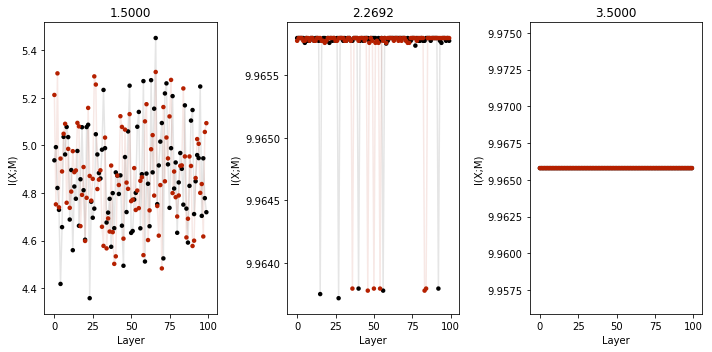

In [52]:
import matplotlib.pyplot as plt
'''
measures[activation][epoch] = cepochdata
cepochdata = {'MI_XM_upper': num_layers*[MI],
              'MI_XM_lower': num_layers*[MI],
             } 

'''
COLORBAR_MAX_EPOCHS = num_epoch
max_epoch = num_epoch
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for T_index, (T, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    plt.subplot(1,3,T_index+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = range(num_layers)
        ymvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]

        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)
    
#     plt.ylim([9.65, 9.675])
#     plt.xlim([0, 14])
    plt.xlabel('Layer')
    plt.ylabel('I(X;M)')
    plt.title(T)
    
# cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

if DO_SAVE:
    plt.savefig('MI_Ising2D.png',bbox_inches='tight')
    